### This notebook is used to train GPR models and write result

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gpflow
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
matplotlib.rcParams['figure.figsize'] = (12, 6)

/Users/Tianyi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/Tianyi/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


Please make sure your GPflow version is at least 1.1.1

In [3]:
gpflow.__version__

'1.1.1'

In [4]:
region = 'VT'

In [5]:
df_train = pd.read_csv('Data/' + region + '_train.csv')

#### remove outlier

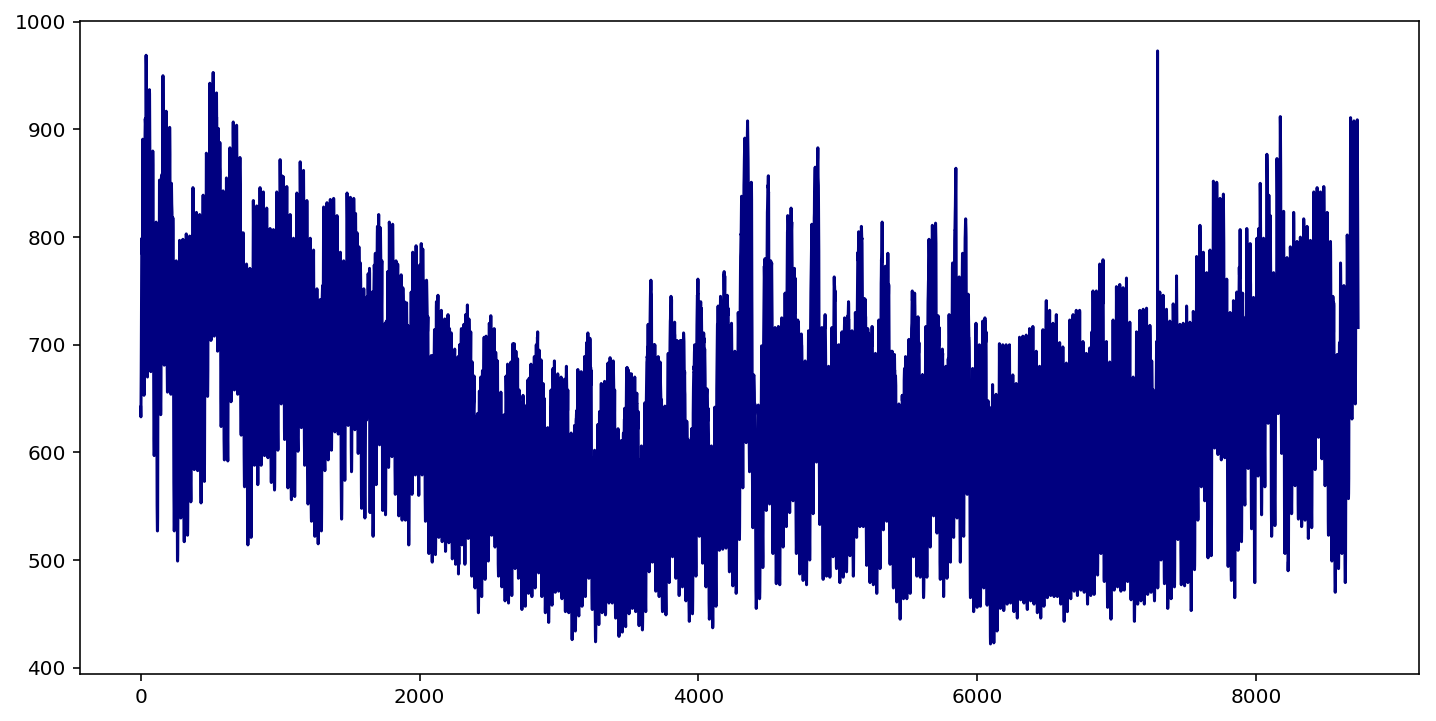

In [6]:
demand = df_train['DEMAND'].values
demand = demand[:]
plt.plot(range(demand.shape[0]), demand, color='navy', label='True')

Removing by hand

In [7]:
outcheck = df_train[6000:8000]
outcheck[df_train['DEMAND']>950]


/Users/Tianyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Date,Hour,DEMAND,Month,Day,Weekday,D1,D2,D3,D4,...,Y4,Y5,1D,2D,3D,4D,5D,6D,7D,Weekend?
7292,2014-11-02,2,973.0,11,2,6,1049.0,1075.0,1122.0,1200.0,...,1033.0,1090.0,1049.0,1075.0,1050.0,1055.0,1051.0,1032.0,1043.0,1


In [8]:
df_train = df_train.drop([7292, 7316, 7340, 7364, 7388, 7412, 7436, 7460])

#### Regularization, selecting features

In [9]:
df_train['HourOfYear'] = pd.DatetimeIndex(df_train['Date']).dayofyear * 24 + df_train['Hour'] - 24

df_dev = pd.read_csv('Data/' + region+'_dev.csv')
df_dev['HourOfYear'] = pd.DatetimeIndex(df_dev['Date']).dayofyear * 24 + df_dev['Hour'] - 24

df_dev2 = pd.read_csv('Data/' + region+'_dev2.csv')
df_dev2['HourOfYear'] = pd.DatetimeIndex(df_dev2['Date']).dayofyear * 24 + df_dev2['Hour'] - 24

load_scaler = preprocessing.StandardScaler().fit(df_train['DEMAND'].values.reshape(-1,1))
for cols in ['DEMAND', '1D', '2D', '3D', '4D', '5D', '6D', '7D']:
    df_train[cols] = load_scaler.transform(df_train.loc[:,cols].values.reshape(-1, 1))
    df_dev[cols] = load_scaler.transform(df_dev.loc[:,cols].values.reshape(-1, 1))
    df_dev2[cols] = load_scaler.transform(df_dev2.loc[:,cols].values.reshape(-1, 1))
    
for cols in ['Weekday', 'Weekend?', 'Day', 'Hour', 'Month']:
    cataScaler = preprocessing.StandardScaler()
    df_train[cols] = cataScaler.fit_transform(df_train.loc[:,cols].values.reshape(-1, 1))
    df_dev[cols] = cataScaler.transform(df_dev.loc[:,cols].values.reshape(-1, 1))
    df_dev2[cols] = cataScaler.transform(df_dev2.loc[:,cols].values.reshape(-1, 1))

df_gpr_train = df_train[['DEMAND', '1D', '2D', '3D', '4D', '5D', '6D', '7D','Weekday','Weekend?']]
df_gpr_dev = df_dev[['DEMAND', '1D', '2D', '3D', '4D', '5D', '6D', '7D','Weekday','Weekend?']]
df_gpr_dev2 = df_dev2[['DEMAND', '1D', '2D', '3D', '4D', '5D', '6D', '7D','Weekday','Weekend?']]

Y = df_gpr_train['DEMAND']
X = df_gpr_train.drop(['DEMAND'], axis = 1)

Y_s = df_gpr_dev['DEMAND'].values.reshape([-1,1])
X_s = df_gpr_dev.drop(['DEMAND'], axis = 1).values

Y_2 = df_gpr_dev2['DEMAND'].values.reshape([-1,1])
X_2 = df_gpr_dev2.drop(['DEMAND'], axis = 1).values


/Users/Tianyi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### Train and write result

In [11]:
for i in range(5):
    df_sampled = df_gpr_train.sample(2000)
    Y = df_sampled['DEMAND'].values.reshape([-1,1])
    X = df_sampled.drop(['DEMAND'], axis = 1).values
    with gpflow.defer_build():
        m = gpflow.models.GPR(X, Y, kern= gpflow.kernels.Matern32(input_dim=X.shape[1], ARD=True) 
                              + gpflow.kernels.RBF(input_dim=X.shape[1])) 
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    
    mean, var = m.predict_y(X_2)
    y_true = load_scaler.inverse_transform(Y_2.reshape(-1,1))
    y_pred = load_scaler.inverse_transform(mean)
    s_pred = np.sqrt(load_scaler.var_ * var)
    d = {'mean': y_pred[:,0], 'sigma': s_pred[:,0]}
    result = pd.DataFrame(data=d)
    result.to_csv('results/GPR_'+region+'_result'+str(i+1)+'.csv', index = False)    

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 898.637516
  Number of iterations: 71
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 898.637516
  Number of iterations: 71
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 887.702278
  Number of iterations: 95
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 887.702278
  Number of iterations: 95
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1012.455673
  Number of iterations: 102
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1012.455673
  Number of iterations: 102
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 986.733960
  Number of iterations: 67
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 986.733960
  Number of iterations: 67
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1013.940233
  Number of iterations: 54
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1013.940233
  Number of iterations: 54
  Number of functions evaluations: 103
